# Проект предсказания рисков для здоровья при беременности

## Вступление

### Описание проекта:

Беременность - критический период в жизни женщины, и мониторинг здоровья матери является важным для обеспечения благополучия как матери, так и нерожденного ребенка. Этот проект сосредоточен на использовании методов машинного обучения для прогнозирования уровня риска для беременных женщин на основе ключевых атрибутов здоровья.

### Описание данных:

* Age: Возраст в годах, когда женщина беременна
* BodyTemp: Температура тела, измеряемая в фаренгейтах
* SystolicBP: Верхнее значение артериального давления в мм рт. ст., другой значимый атрибут во время беременности
* DiastolicBP: Нижнее значение артериального давления в мм рт. ст., другой значимый атрибут во время беременности
* BS: Уровень глюкозы в крови, измеряемый молярной концентрацией, ммоль/л
* HeartRate: Нормальная частота сердечных сокращений в минуту
* Risk Level: Предсказанный уровень риска во время беременности, учитывая предыдущие атрибуты

### В чем состоит задача?

Создать прогностическую модель рисков беременных

## Предобработка и анализ данных

### Загрузка библиотек и данных

Подгружаем нужные нам библиотеки и задаем глобальные переменные

In [12]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score 
import shap

import os
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
RND_ST = 12345

Расширяем рабочее пространство экрана и выравниваем его по краям

In [16]:
from IPython.core.display import display, HTML
display(HTML("""
<style>
.container { 
   width:90% !important; 
   position: relative; 
   right: 25px; 
}
</style>
"""))

C:\Users\temoc\AppData\Local\Temp\ipykernel_2848\2057739371.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Загружаем данные нам датасеты, проверяя что путь верный

In [18]:
def pth_exist(pth):
    if os.path.exists(pth):
        try:
            df = pd.read_csv(pth)
            return df
        except Exception as e:
            print(f'Ошибка при чтении файла: {e}')
            return None
    else:
        print('Путь не таков')
        return None

In [19]:
df = pth_exist(r'C:\Users\temoc\OneDrive\Рабочий стол\kaggle\pregnant\data\health.csv')

### Анализ и обработка сырых данных

Делаем функцию для выдачи общей информации по датасету

In [22]:
def info_func(df):
    print('Общая информация')
    print('')
    df.info()
    print('')
    print(df.describe())
    print('')
    print('Кол-во пропущенных значений')
    print('')
    print(df.isna().sum().sort_values(ascending=False))
    print('')
    print('Процент пропущенных значений')
    print('')
    print((df.isna().sum()/len(df)*100).sort_values(ascending=False))
    print('')
    print('Как выглядит датасет')
    print('')
    print(df.head(10))

Выведем общую информацию

In [24]:
info_func(df)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB

               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.

* Как мы можем заметить данные не содержат пропусков. 
* В столбце HeartRate есть аномальное минимальное значение 7. Немного изучив вопрос, я уберу все значения пульса ниже 35. 
* В столбце Age есть аномальное минимальное значение 10. Немного изучив вопрос, я уберу все значения возраста ниже 14. 
* С остальными столбцами вероятно все в порядке.

In [26]:
df = df[~(df['HeartRate'] < 35)]

In [27]:
df = df[~(df['Age'] < 14)]

Делим данные на признаки и целевое значение

In [29]:
features=df.drop(['RiskLevel'],axis=1)
target=df['RiskLevel']

Посмотрим на распределение признаков

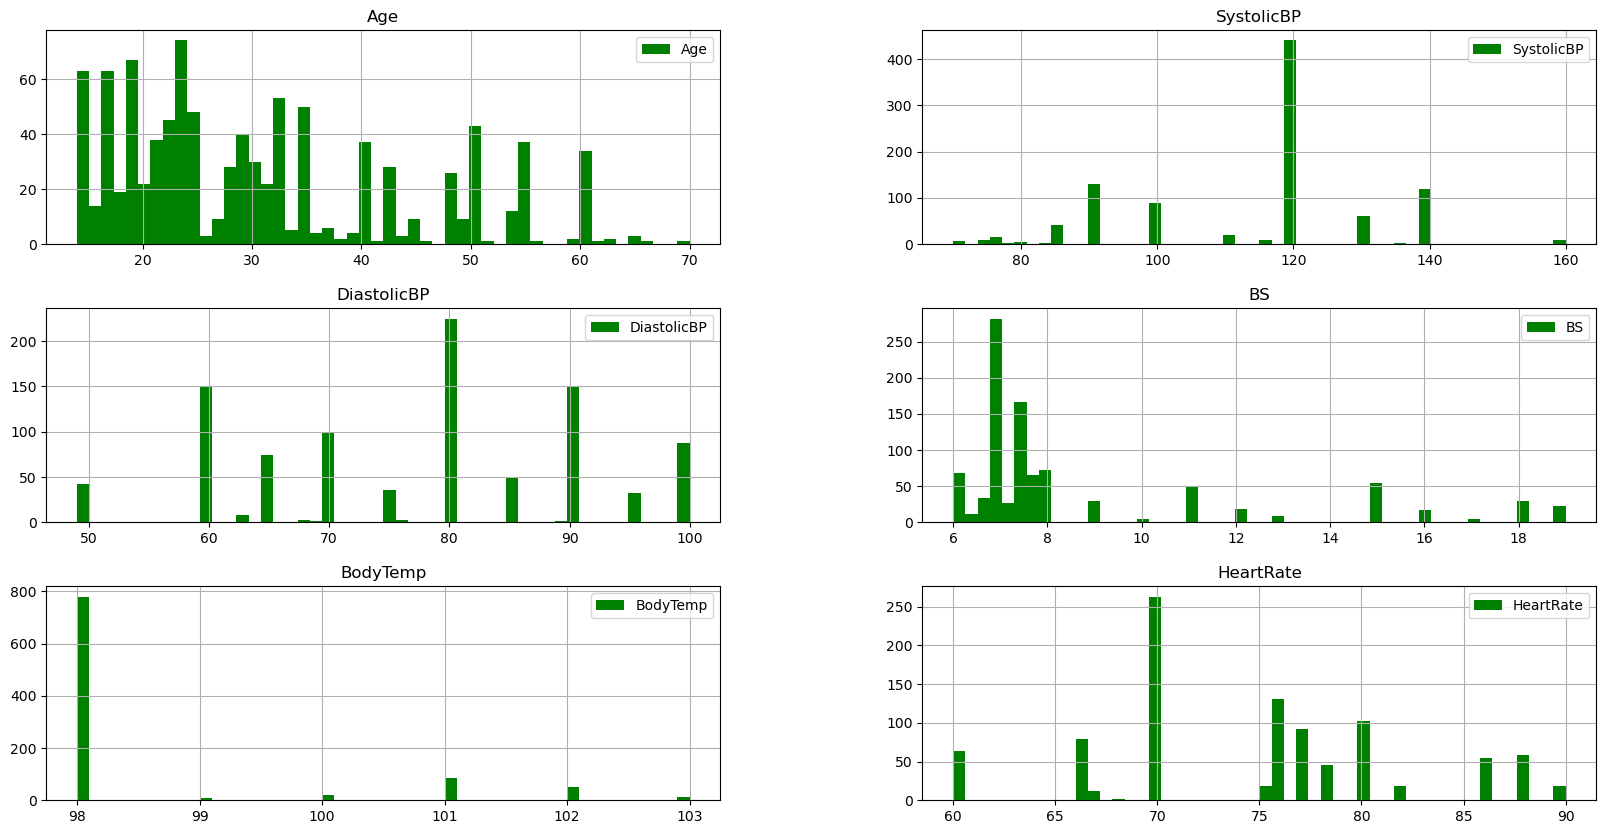

In [31]:
features.hist(bins=50, figsize=(20,10), legend = True, color='green')
plt.show()

Посмотрим на распределение целевого признака

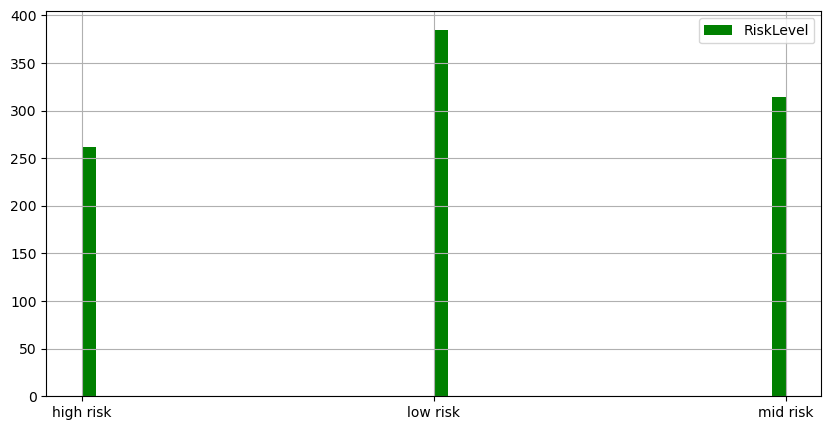

In [33]:
target.hist(bins=50, figsize=(10,5), legend = True, color='green')
plt.show()

Меньше всего людей с высоким риском для здоровья при беременности

### Корреляция

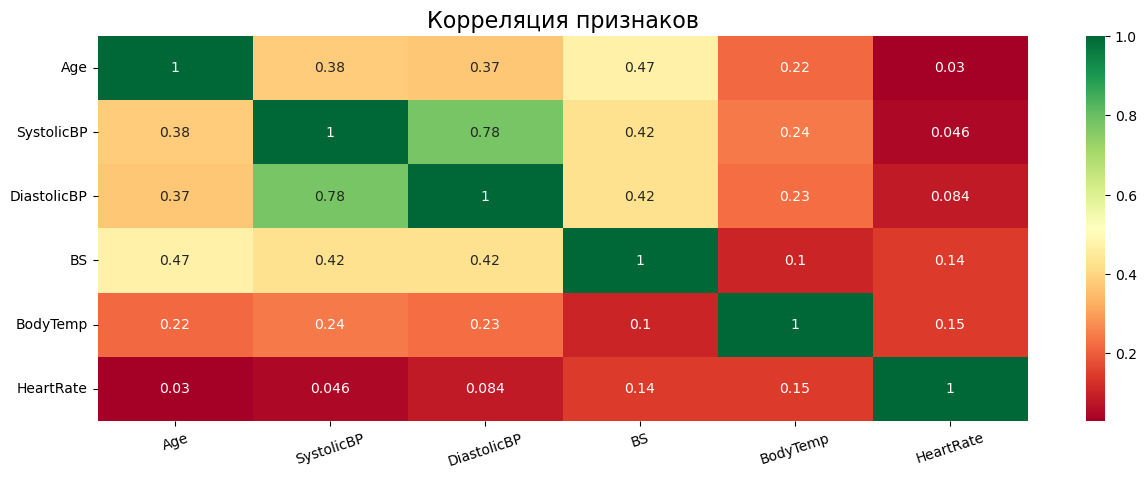

In [36]:
plt.figure(figsize=(15,5))
fig = sns.heatmap(features.corr().abs(), cmap='RdYlGn', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

Позднее, я заметил, что возникла мультиколлинеарность между SystolicBP и DiastolicBP, и, исходя из результатов важности следующей главы, я решил удалить DiastolicBP, т.к. это менее важный признак, чем SystolicBP

In [38]:
features = features.drop(["DiastolicBP"], axis=1)

### Вывод по предобработке и анализу данных

* Удалены аномальные значения
* Исправлена мультиколлинеарность

## Обучение модели

### Разделение на тренировочную и тестовую выборки

Делим на тренировочную и тестовую выборки

In [44]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RND_ST, shuffle=True
)

display(features_train.shape)
display(features_test.shape)

(720, 5)

(241, 5)

### Выбор лучшей модели

Подберем лучшие гиперпараметры для CatBoostClassifier

In [47]:
param_grid = {
    'learning_rate': [0.1],
    'depth': [6],
    'l2_leaf_reg': [3],
    'iterations': [1000]
}

model = CatBoostClassifier(random_state=RND_ST, verbose=False)  # Отключаем вывод CatBoost
cat_grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=0)
cat_grid.fit(features_train, target_train)

train_predictions = cat_grid.predict(features_train)
f_train = f1_score(target_train, train_predictions, average='micro')

print(f'f1_score (train): {f_train:.2f}')
print("Лучшие параметры:", cat_grid.best_params_)
print("Score:", cat_grid.best_score_)

f1_score (train): 0.93
Лучшие параметры: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Score: 0.8430555555555557


In [48]:
param_grid = {
    'learning_rate': [0.1],
   'depth': [6],
    'l2_leaf_reg': [3],
   'iterations': [1000]
}
model = CatBoostClassifier(random_state=RND_ST, verbose=False)
cat_grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=0)
cat_grid.fit(features_train, target_train)
train_predictions = cat_grid.predict(features_train)
f_train = f1_score(target_train, train_predictions, average='micro')
print(f'f1_score (train): {f_train:.2f}')
print("Лучшие параметры: ",cat_grid.best_params_)
print("Score: ", cat_grid.best_score_)

f1_score (train): 0.93
Лучшие параметры:  {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Score:  0.8430555555555557


### Тестирование лучшей модели и важность признаков

Протестируем CatBoostClassifier на тестовых данных со следующими параметрами подобранными на кросс-валидации: depth=6, iterations=1000, learning_rate=0.1, verbose=100, l2_leaf_reg = 3

In [51]:
cbc = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg = 3, learning_rate=0.1, verbose=100, random_state = RND_ST)
cbc.fit(features_train, target_train)
test_predictions = cbc.predict(features_test)
f_test = f1_score(target_test, test_predictions, average='micro')
print(f"F1_Score: {f_test:.2f}")

0:	learn: 1.0350783	total: 1.09ms	remaining: 1.09s
100:	learn: 0.4155246	total: 68.7ms	remaining: 612ms
200:	learn: 0.3227806	total: 135ms	remaining: 536ms
300:	learn: 0.2749764	total: 206ms	remaining: 478ms
400:	learn: 0.2459232	total: 274ms	remaining: 409ms
500:	learn: 0.2267159	total: 341ms	remaining: 340ms
600:	learn: 0.2131440	total: 410ms	remaining: 272ms
700:	learn: 0.2036163	total: 476ms	remaining: 203ms
800:	learn: 0.1962142	total: 546ms	remaining: 136ms
900:	learn: 0.1902737	total: 615ms	remaining: 67.5ms
999:	learn: 0.1853623	total: 682ms	remaining: 0us
F1_Score: 0.85


Строим графики важности признаков

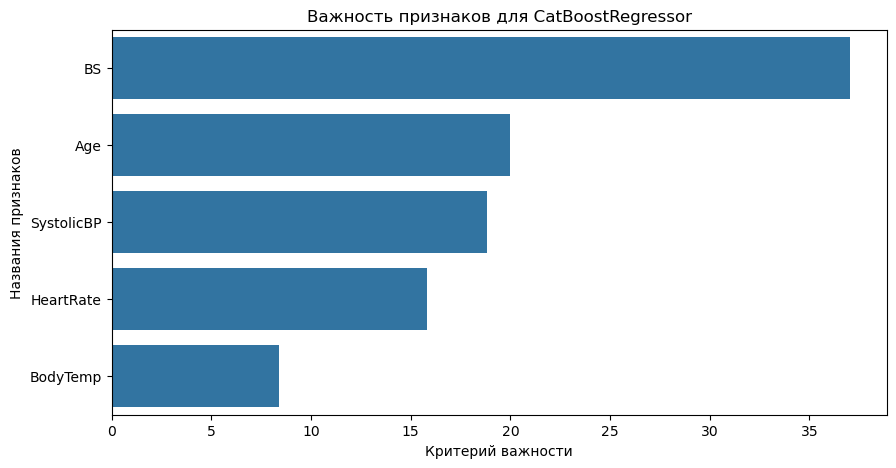

In [53]:
plot_data = {
    'features': features_test.columns,
    'feature_importance': cbc.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=plot_data['feature_importance'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Тут я применил график SHAP, чтобы понять как признаки различных величин влияют на итоговое предсказание

Для 1 класса

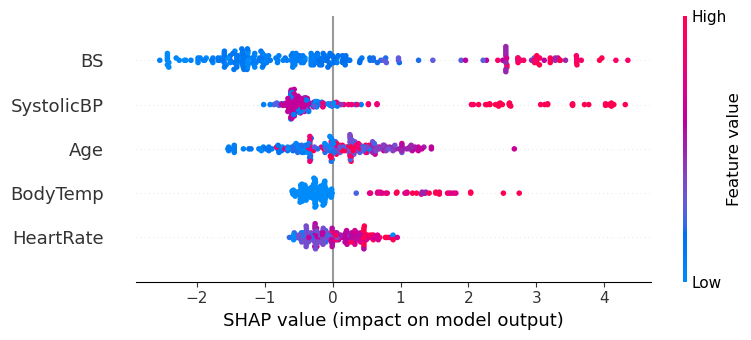

None

In [64]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(features_test)
shap_values_for_class = shap_values[:, :, 0] 
display(shap.force_plot(explainer.expected_value[0], shap_values_for_class[0,:], features_test.iloc[0,:]))
display(shap.summary_plot(shap_values_for_class, features_test))

Для 2 класса

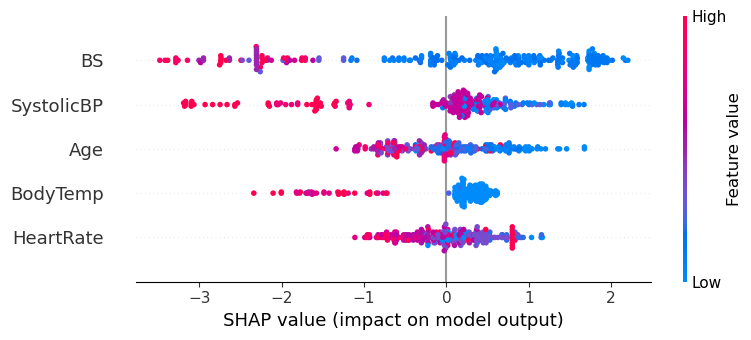

None

In [66]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(features_test)
shap_values_for_class = shap_values[:, :, 1] 
display(shap.force_plot(explainer.expected_value[0], shap_values_for_class[0,:], features_test.iloc[0,:]))
display(shap.summary_plot(shap_values_for_class, features_test))

Для 3 класса

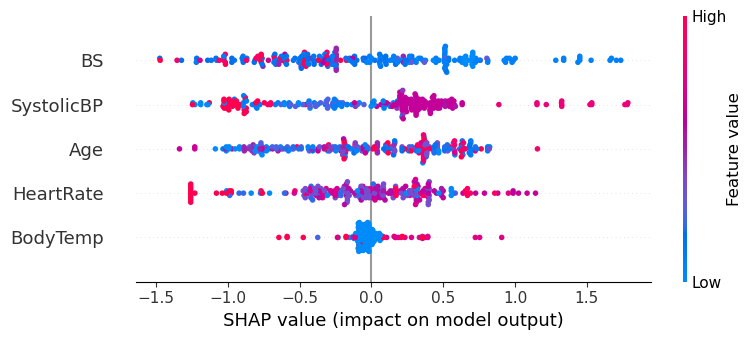

None

In [72]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(features_test)
shap_values_for_class = shap_values[:, :, 2] 
display(shap.force_plot(explainer.expected_value[0], shap_values_for_class[0,:], features_test.iloc[0,:]))
display(shap.summary_plot(shap_values_for_class, features_test))

Как мы можем видеть из двух графиков выше - BS имеет наибольшую значимость для модели CatBoostRegression:

* Чем выше значение BS, тем лучше для предсказаний модели
* В свою очередь низкие значения SystolicBP ухудшают предсказания

### Вывод по тестированию и важности признаков

* На тестовой выборке модель CatBoostClassifier показала результат на метрике F1 равный 0,85 при следующих параметрах модели: depth=6, iterations=1000, l2_leaf_reg = 3, learning_rate=0.1, verbose=100
* Наиболее важным признаком является BS и, чем выше его значение, тем лучше для предсказаний модели

## Общий вывод

Я достиг результата в 85% точности на тестовой выборке, согласно метрике F1. Этот результат можно улучшить, если еще точнее настроить гиперпараметры для нашей модели, или добавить новых признаков.  

### Вывод требуемых метрик и матриц ошибок

F1_Score_train: 0.93



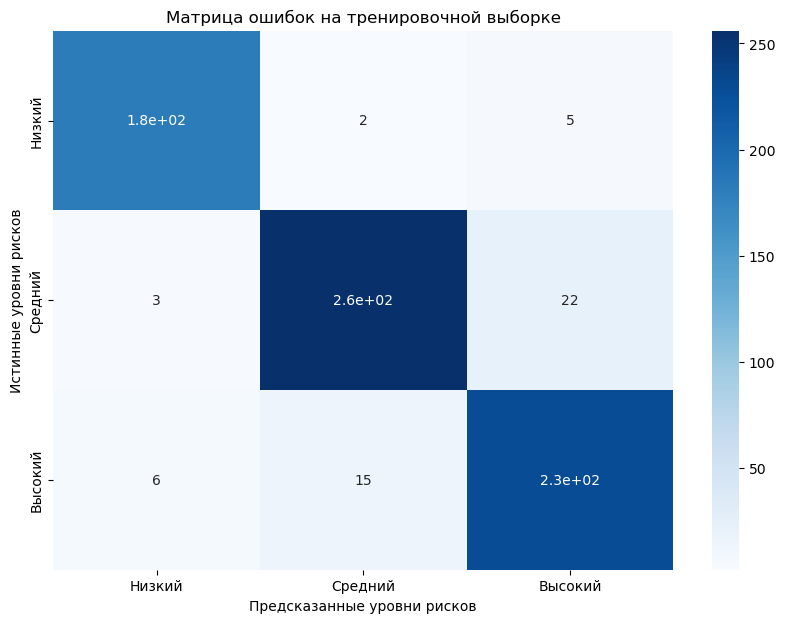

In [77]:
print(f"F1_Score_train: {f_train:.2f}")
print()
cm_train = confusion_matrix(target_train, train_predictions)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm_train, annot=True, cmap='Blues', ax=ax)
ax.set_title('Матрица ошибок на тренировочной выборке')
ax.set_xlabel("Предсказанные уровни рисков")
ax.set_ylabel("Истинные уровни рисков")
ax.set_xticklabels(["Низкий", "Средний", "Высокий"])
ax.set_yticklabels(["Низкий", "Средний", "Высокий"])
plt.show()

F1_Score_test: 0.85



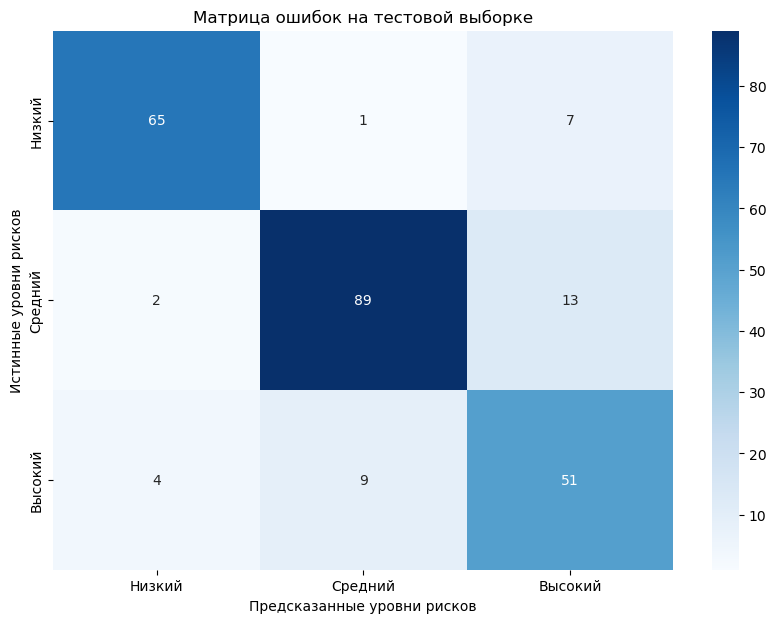

In [78]:
print(f"F1_Score_test: {f_test:.2f}")
print()
cm_test = confusion_matrix(target_test, test_predictions)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, cmap='Blues', ax=ax)
ax.set_title('Матрица ошибок на тестовой выборке')
ax.set_xlabel("Предсказанные уровни рисков")
ax.set_ylabel("Истинные уровни рисков")
ax.set_xticklabels(["Низкий", "Средний", "Высокий"])
ax.set_yticklabels(["Низкий", "Средний", "Высокий"])
plt.show()